# Multivariate Time-Series Forecasting: Predict Iron Prices

In [1]:
n_future= 3 # number of moths to be predicted
n_past= 24 # the size of the windowed dataframe

### Import libs

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from pylab import rcParams


from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam


In [2]:
# Create date column for both dataframes:
# this function takes a string object which is in a date format and covert it to a date object
def str_to_datetime(s):
  split = s.split('/')
  month, day, year = int(split[0]), int(split[1]), int(split[2])
  return dt.datetime(year=year, month=month, day=day)

def str_to_datetime_ii(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return dt.datetime(year=year, month=month, day=day)

## Part 1: Data preprocessing

###  Read and load the data; we want to select the features for the training and prediction and extract the date column then make it the index

Index & Date columns...

In [8]:
# read the data and convert index to date:

#            iron_12mm
df_iron_12mm= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\iron ore\price 12mm iron.xlsx')
# create column to concatenate the day, month and year
df_iron_12mm['date'] = df_iron_12mm['month'].map(str)+ '/'  + '1' + '/' + df_iron_12mm['year'].map(str)
# apply the function str_to_datetime on df_iron_12mm & assign date to be the new indexes
df_iron_12mm['date'] = df_iron_12mm['date'].apply(str_to_datetime)
df_iron_12mm.index = df_iron_12mm.pop('date')
# we keep only the needed columns
df_iron_12mm= pd.DataFrame(df_iron_12mm['price'])
df_iron_12mm.columns= ['iron_12mm']

# #           iron_10mm
# df_iron_10mm= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\Project PoC\Input\data\iron ore\price 10mm iron.xlsx')
# # create column to concatenate the day, month and year
# df_iron_10mm['date'] = df_iron_10mm['month'].map(str)+ '/'  + '1' + '/' + df_iron_10mm['year'].map(str)
# # apply the function str_to_datetime on df_iron_10mm & assign date to be the new indexes
# df_iron_10mm['date'] = df_iron_10mm['date'].apply(str_to_datetime)
# df_iron_10mm.index = df_iron_10mm.pop('date')
# # we keep only the needed columns
# df_iron_10mm= pd.DataFrame(df_iron_10mm['price'])
# df_iron_10mm.columns= ['iron_10mm']

#           oil
df_oil_brent= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Oil\Brent Oil Futures Historical Data; monthly.csv')
df_oil_brent['Date'] = df_oil_brent['Date'].apply(str_to_datetime)
df_oil_brent.index = df_oil_brent.pop('Date')
# we keep only the needed columns
df_oil_brent= pd.DataFrame(df_oil_brent['Price'])
df_oil_brent.columns= ['oil_brent']

#           TASI
df_TASI= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Markets\Tadawul All Share Historical Data monthly.csv')
df_TASI['Date'] = df_TASI['Date'].apply(str_to_datetime)
df_TASI.index = df_TASI.pop('Date')
# we keep only the needed columns
df_TASI= pd.DataFrame(df_TASI['Price'])
df_TASI.columns= ['tasi']

#           gold
df_gold= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\gold\Gold Futures Historical Data monthly.csv')
df_gold['Date'] = df_gold['Date'].apply(str_to_datetime)
df_gold.index = df_gold.pop('Date')
# we keep only the needed columns
df_gold= pd.DataFrame(df_gold['Price'])
df_gold.columns= ['gold']


#           fed fund
df_fed_fund= pd.read_csv(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Fed fund rates\FEDFUNDS.csv')
df_fed_fund['Date'] = df_fed_fund['DATE'].apply(str_to_datetime_ii)
df_fed_fund.index = df_fed_fund.pop('Date')
# we keep only the needed columns
df_fed_fund= pd.DataFrame(df_fed_fund['FEDFUNDS'])
df_fed_fund.columns= ['fed_fund']



#   ----->>> JOIN <<<-----
# join the two dataframes based on date index to create the traing dataset
# dataset_train = pd.merge(df_iron_12mm,df_iron_10mm, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(df_iron_12mm,df_oil_brent, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(dataset_train,df_TASI, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(dataset_train,df_gold, how='left', left_index=True, right_index=True)
dataset_train = pd.merge(dataset_train,df_fed_fund, how='left', left_index=True, right_index=True)


#  Add historical data
dataset_train['lag_1']= dataset_train['iron_12mm'].shift(1)

dataset_train['lag_1'].fillna(value=dataset_train['lag_1'].mean(), inplace=True)

# dataset_train= pd.DataFrame(
#     {
#         'date': dataset_train.index,
#         'iron_12mm': dataset_train['iron_12mm'],
#         'oil_brent': dataset_train['oil_brent'],
#         'tasi': dataset_train['tasi'],
#         'gold': dataset_train['gold'],
#         'fed_fund': dataset_train['fed_fund'],
#         'lag_1': dataset_train['lag_1']
#     }, index= dataset_train.index
# )

dataset_train

,iron_12mm,oil_brent,tasi,gold,fed_fund,lag_1
date,,,,,,
2013-01-01,2964.917,114.54,"7,043.55","1,662.00",0.14,2615.09244
2013-02-01,2964.750,110.42,"6,998.33","1,578.90",0.15,2964.91700
2013-03-01,2964.942,109.79,"7,125.73","1,595.70",0.14,2964.75000
2013-04-01,2964.917,102.04,"7,179.80","1,472.70",0.15,2964.94200
2013-05-01,2964.917,100.20,"7,404.12","1,393.00",0.11,2964.91700
...,...,...,...,...,...,...
2022-05-01,4000.960,115.60,"12,921.74","1,848.40",0.77,4032.60000
2022-06-01,3704.880,109.03,"11,523.25","1,812.00",1.21,4000.96000
2022-07-01,3595.940,103.97,"12,199.08","1,771.50",1.68,3704.88000


In [24]:
dataset_train= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated\حديد تسليح 12مم وطني.xlsx')
dataset_train.index= dataset_train.pop('date')
dataset_train

,price,oil_brent,tasi,gold,interest_rate,historical
date,,,,,,
2013-01-01,2964.917,114.54,"7,043.55","1,662.00",0.14,2615.09244
2013-02-01,2964.750,110.42,"6,998.33","1,578.90",0.15,2964.91700
2013-03-01,2964.942,109.79,"7,125.73","1,595.70",0.14,2964.75000
2013-04-01,2964.917,102.04,"7,179.80","1,472.70",0.15,2964.94200
2013-05-01,2964.917,100.20,"7,404.12","1,393.00",0.11,2964.91700
...,...,...,...,...,...,...
2022-05-01,4000.960,115.60,"12,921.74","1,848.40",0.77,4032.60000
2022-06-01,3704.880,109.03,"11,523.25","1,812.00",1.21,4000.96000
2022-07-01,3595.940,103.97,"12,199.08","1,771.50",1.68,3704.88000


In [25]:
# select features (columns) to be involved into training and predictions
cols= list(dataset_train)[:]
# make the dataframe on a monthly basis
dataset_train= dataset_train.to_period(freq='m')
# dataset_train= list(dataset_train.index)

# EXTRACT dates:
# store the date index in a list 
datelist_train= dataset_train.index.strftime('%Y-%m')
datelist_train= [dt.datetime.strptime(date, '%Y-%m').date() for date in datelist_train]



In [26]:
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('columns selected: {}'.format(cols))
print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))

Training set shape == (117, 6)
All timestamps == 117
columns selected: ['price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
Sample of date list: [datetime.date(2013, 1, 1), datetime.date(2013, 2, 1)]...[datetime.date(2022, 7, 1), datetime.date(2022, 8, 1)]


###  Shaping and transformation

In [27]:
# make sure there are no commas in any number
dataset_train= dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j]= dataset_train[i][j].replace(',','')
dataset_train= dataset_train[cols].astype(float)

# Using multiple predictors (features)
# we need convert (reshape) to a matrix(array) using .to_numpy
training_set= dataset_train.to_numpy()
print('Shape of training set == {}.'.format(training_set.shape))

Shape of training set == (117, 6).


## Scaling...

In [28]:
sc= StandardScaler()
training_set_scaled= sc.fit_transform(training_set)

sc_predict= StandardScaler()
sc_predict.fit_transform(training_set[:,0:1])# our target (iron_12mm) / the dependant variable


array([[ 0.71446457],
       [ 0.71411927],
       [ 0.71451626],
       [ 0.71446457],
       [ 0.71446457],
       [ 0.71446457],
       [ 0.71446457],
       [ 0.71446457],
       [ 0.71368919],
       [ 0.55146179],
       [ 0.44532204],
       [ 0.41024813],
       [ 0.41024813],
       [ 0.38914755],
       [ 0.37304659],
       [ 0.35864113],
       [ 0.31660951],
       [ 0.30796665],
       [ 0.27551042],
       [ 0.22619026],
       [ 0.1212146 ],
       [ 0.06128522],
       [-0.02447143],
       [-0.06548576],
       [-0.28403238],
       [-0.33250273],
       [-0.47783312],
       [-0.52554256],
       [-0.54460856],
       [-0.53537227],
       [-0.53689821],
       [-0.53842415],
       [-0.85035301],
       [-0.89085868],
       [-1.30897072],
       [-1.36811851],
       [-1.39142323],
       [-1.39472737],
       [-1.39269278],
       [-1.07703385],
       [-0.61079264],
       [-0.59020071],
       [-0.59274187],
       [-0.63556954],
       [-0.81239057],
       [-1

## Part 2: Modeling

###  Build the model architecture and Set up the WINDOWED DATAFRAME 

In [29]:
len(training_set_scaled) - 24+1

94

In [30]:
dataset_train.shape[1] - 1

5

In [31]:
# Create a data structure with timestamps
X_train= []
y_train= []
n_future= 6 # number of moths to be predicted
n_past= 12 # the size of the windowed dataframe

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (100, 12, 5).
y_train shape == (100, 1).


## Build the model architecture

In [32]:
model= Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
model.add(Dropout(.30))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(.20))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer= Adam(learning_rate=.016), loss= 'mean_squared_error')

## Train the model

In [33]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=50, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)

Epoch 1/50
1/3 [=========>....................] - ETA: 5s - loss: 0.5763
Epoch 1: val_loss improved from inf to 0.75981, saving model to weights.h5
3/3 [==============================] - 3s 341ms/step - loss: 0.4308 - val_loss: 0.7598 - lr: 0.0160
Epoch 2/50
1/3 [=========>....................] - ETA: 0s - loss: 0.1368
Epoch 2: val_loss did not improve from 0.75981
3/3 [==============================] - 0s 26ms/step - loss: 0.1659 - val_loss: 0.7775 - lr: 0.0160
Epoch 3/50
1/3 [=========>....................] - ETA: 0s - loss: 0.2120
Epoch 3: val_loss did not improve from 0.75981
3/3 [==============================] - 0s 26ms/step - loss: 0.1563 - val_loss: 0.8645 - lr: 0.0160
Epoch 4/50
1/3 [=========>....................] - ETA: 0s - loss: 0.1155
Epoch 4: val_loss did not improve from 0.75981
3/3 [==============================] - 0s 26ms/step - loss: 0.1005 - val_loss: 0.9035 - lr: 0.0160
Epoch 5/50
1/3 [=========>....................] - ETA: 0s - loss: 0.1169
Epoch 5: val_loss did 

###  training and testing
## Part 3: Forcasting

In [34]:
# Generate list of sequence of months for predictions w datetime type
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
datelist_future_= []
for d in datelist_future:
    d= d + dt.timedelta(days=1)
    d= d.date()
    datelist_future_.append(d)
# (datelist_future_)

# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

3/3 [==============================] - 0s 4ms/step


### Step 5: Predict the future

In [35]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return dt.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['predicted']).set_index(pd.Series(datelist_future_))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert  to  for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index#.to_series()#.apply(datetime_to_timestamp)



3/3 [==============================] - 0s 4ms/step


In [36]:
PREDICTION_TRAIN
res= PREDICTION_TRAIN.append(PREDICTIONS_FUTURE)
res['iron_prices']= df_iron_12mm
res

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8580\1183576165.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res= PREDICTION_TRAIN.append(PREDICTIONS_FUTURE)


,predicted,iron_prices
2015-06-01,2373.066162,2360.451
2015-07-01,2349.034180,2359.713
2015-08-01,2305.448242,2358.975
2015-09-01,2263.987793,2208.115
2015-10-01,2193.932129,2188.525
...,...,...
2022-11-01,2666.498291,NaN
2022-12-01,2551.838867,NaN
2023-01-01,2471.708008,NaN
2023-02-01,2449.171631,NaN


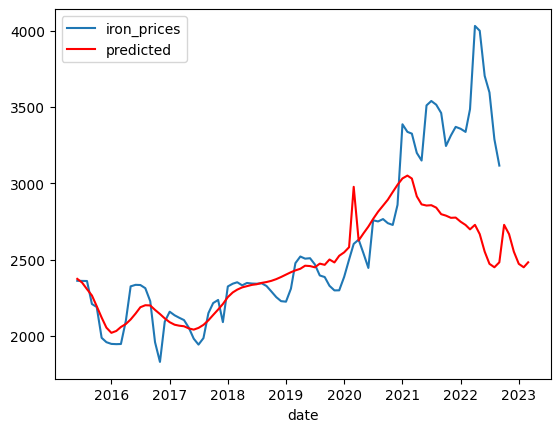

In [37]:
res['date']= res.index
res.columns[-1]
df= res

ax = plt.gca()
df.plot(kind='line',x=res.columns[-1],y='iron_prices',ax=ax)
df.plot(kind='line',x=res.columns[-1],y='predicted', color='red', ax=ax)


plt.show()

In [99]:
res.to_csv(r'C:\Users\fnafisa\WORKSPACE\Project PoC\output\predictions.csv', encoding='utf-8', index=False)


In [7]:
def pipeline(filename_str, first_layer_nodes, adam_learning_rate, drp1, drp2):
    # import training dataset
    filename_w_extension= filename_str+'.xlsx'
    filepath= r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated'+f'\{filename_w_extension}'
    dataset_train= pd.read_excel(filepath)
    element_name= dataset_train.pop('element_name')[0]
    dataset_train.columns = ['date','price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
    dataset_train= dataset_train.sort_values(by=['date'], ascending=True)

    # features selection
    cols= list(dataset_train)[1:]

    # Extract dates (timestamp format)
    datelist_train = list(dataset_train['date'])
    
    # dataset_train.index= dataset_train.pop('date')
    print(dataset_train)
    print('Training set shape == {}'.format(dataset_train.shape))
    print('All timestamps == {}'.format(len(datelist_train)))
    print('Featured selected: {}'.format(cols))
    print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))
    


    # dataset traing will be the essanse of all the upcoming datasets(training_set, training_set_scaled, X_train, y_train...)
    # make sure there are no commas in any number                                                      "Target"      |--------------------"Predictors"-------------------|
    dataset_train = dataset_train[cols].astype(str) # to remove the date and select only the features : ['price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
    for i in cols:
        for j in range(0, len(dataset_train)):
            dataset_train[i][j] = dataset_train[i][j].replace(',', '')

    dataset_train = dataset_train.astype(float)

    # by using multiple predictors (features) we need to convert (reshape) to a matrix(array) using .to_numpy
    training_set= dataset_train.to_numpy()

    # Feature scaling hence features vary in range
    sc = StandardScaler()
    training_set_scaled = sc.fit_transform(training_set)

    sc_predict = StandardScaler()
    target_scaled= sc_predict.fit_transform(training_set[:, 0:1])

    print('Shape of training set        == {}.'.format(training_set.shape))
    print('Shape of training set scaled == {}.'.format(training_set_scaled.shape))

    # Create a data structure with timestamps
    # Target/features selection
    X_train= []
    y_train= []
    n_future= 6 # number of moths to be predicted
    n_past= 12 # the size of the windowed dataframe

    for i in range(n_past, len(training_set_scaled) - n_future +1):
        X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
        y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print('X_train shape == {}.'.format(X_train.shape))
    print('y_train shape == {}.'.format(y_train.shape))



    # Generate list of sequence of months for predictions w datetime type
    datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
    datelist_future_= []
    for d in datelist_future:
        d= d + dt.timedelta(days=1)
        d= d.date()
        datelist_future_.append(d)
    datelist_future= datelist_future_
    del datelist_future_

    datelist_train_= []
    for this_timestamp in datelist_train:
        datelist_train_.append(this_timestamp.date())
    datelist_train= datelist_train_
    del datelist_train_



    # build the model
    model= Sequential()
    
    model.add(LSTM(units=first_layer_nodes, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
    model.add(Dropout(drp1))

    model.add(LSTM(units=first_layer_nodes//2, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
    model.add(Dropout(drp1))
    

    model.add(LSTM(units=10, return_sequences=False))
    model.add(Dropout(drp2))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer= Adam(learning_rate=adam_learning_rate), loss= 'mean_squared_error')
    # %%time
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
    mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
    tb = TensorBoard('logs')
    history = model.fit(X_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)



    # Perform predictions
    predictions_train = model.predict(X_train[n_past:])
    predictions_future = model.predict(X_train[-n_future:])

    y_pred_future = sc_predict.inverse_transform(predictions_future)
    y_pred_train = sc_predict.inverse_transform(predictions_train)

    # Prediction n_future
    # allocate original data point and predicted data point
    data_point_og, data_point_predicted= sc_predict.inverse_transform(target_scaled[-n_future:]), y_pred_future
    # calculate the factor
    factor= (data_point_og[-1] - data_point_predicted[-1]) / data_point_predicted[-1]

    data_point_predicted_w_factor= (data_point_predicted * factor) + data_point_predicted
    # data_point_predicted_w_factor= data_point_predicted

    # Prediction
    # arr= np.array(data_point_predicted_w_factor)
    # for i in range(n_future):
    #     m= arr.mean()
    #     arr= np.append(arr, m)
    #     arr= np.delete(arr, 0)
    # data_point_predicted_w_factor= arr



    # Visualization
    training_start= 2 * n_past + n_future -1
    PREDICTIONS_FUTURE = pd.DataFrame(data_point_predicted_w_factor, columns=['predicted_forecast']).set_index(pd.Series(datelist_future))
    PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted_training']).set_index(pd.Series(datelist_train[training_start:]))

    dataset_train.index= datelist_train
    # Set plot size 
    from pylab import rcParams
    rcParams['figure.figsize'] = 14, 5

    # Plot parameters
    START_DATE_FOR_PLOTTING = '2013-01-01'

    plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['predicted_forecast'], color='r', label=f'{element_name}')
    plt.plot(PREDICTION_TRAIN.loc[:].index, PREDICTION_TRAIN.loc[:]['predicted_training'], color='r', label='Training predictions')
    plt.plot(dataset_train.loc[:].index, dataset_train.loc[:]['price'], color='b', label=f'Actual "{element_name}" Price')

    plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

    plt.grid(which='major', color='#cccccc', alpha=0.5)

    plt.legend(shadow=True)
    plt.title(f'Predcitions and Acutal: {element_name}', family='Arial', fontsize=12)
    plt.xlabel('Timeline', family='Arial', fontsize=10)
    plt.ylabel('Value', family='Arial', fontsize=10)
    plt.xticks(rotation=45, fontsize=8)
    plt.show()



    
    # final result to export
    df_price= pd.DataFrame(dataset_train.loc[:]['price'])
    df_price
    df_final_res = pd.merge(df_price, PREDICTION_TRAIN, how='left', left_index=True, right_index=True)
    df_final_res
    df_final_res= df_final_res.append(PREDICTIONS_FUTURE)
    df_final_res['element_name']= element_name


    file_location=  r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\output\construction materials price index prediction\{}'
    file_location= file_location.format(filename_w_extension)
    df_final_res.to_excel(file_location)
    
    return df_final_res

          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2964.917     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2964.750     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2964.942     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2964.917     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2964.917     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  4000.960     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  3704.880     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  3595.940     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  3288.840      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  3116.300      85.14  11,405.32  1,672.00           2.56   

     historical  
0    2615.09244  
1    2964.91700  
2    2964.75000  
3    2964.94200  
4    2964

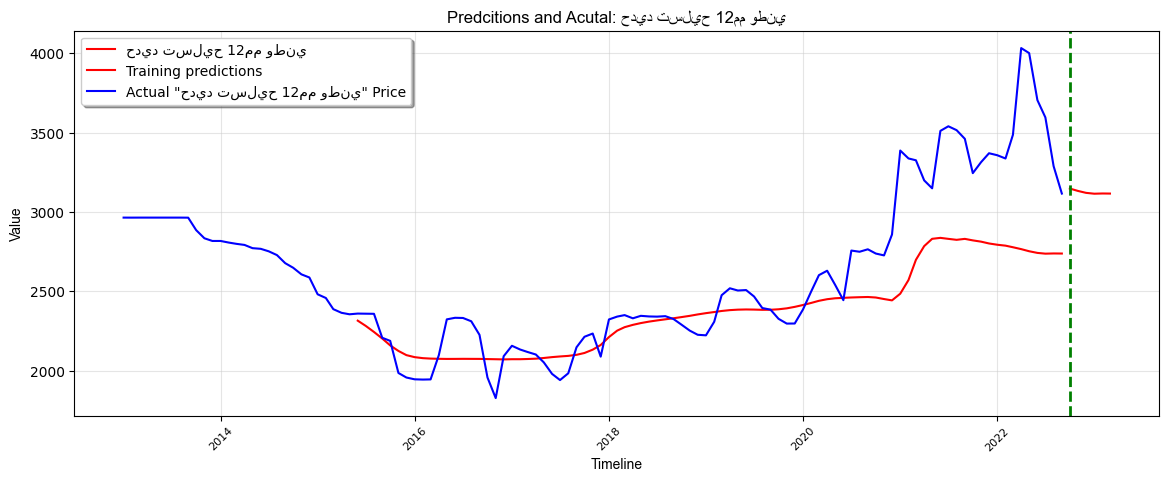

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16952\762470456.py:166: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,2964.917,NaN,NaN,حديد تسليح 12مم وطني
2013-02-01,2964.750,NaN,NaN,حديد تسليح 12مم وطني
2013-03-01,2964.942,NaN,NaN,حديد تسليح 12مم وطني
2013-04-01,2964.917,NaN,NaN,حديد تسليح 12مم وطني
2013-05-01,2964.917,NaN,NaN,حديد تسليح 12مم وطني
...,...,...,...,...
2022-11-01,NaN,NaN,3132.731329,حديد تسليح 12مم وطني
2022-12-01,NaN,NaN,3120.822741,حديد تسليح 12مم وطني
2023-01-01,NaN,NaN,3115.422955,حديد تسليح 12مم وطني
2023-02-01,NaN,NaN,3116.847285,حديد تسليح 12مم وطني


In [21]:
pipeline('حديد تسليح 12مم وطني', first_layer_nodes= 128, drp1= .01, drp2= .01, adam_learning_rate=.005 )

          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2964.917     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2964.750     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2964.942     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2964.917     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2964.917     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  4000.960     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  3704.880     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  3595.940     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  3288.840      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  3116.300      85.14  11,405.32  1,672.00           2.56   

     historical  
0    2615.09244  
1    2964.91700  
2    2964.75000  
3    2964.94200  
4    2964

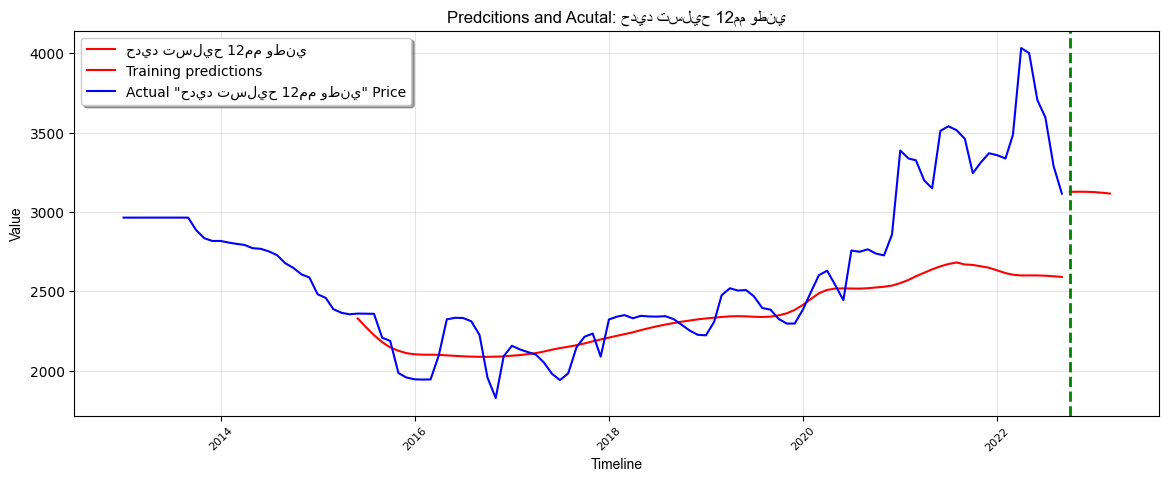

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16952\762470456.py:166: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final_res= df_final_res.append(PREDICTIONS_FUTURE)


,price,predicted_training,predicted_forecast,element_name
2013-01-01,2964.917,NaN,NaN,حديد تسليح 12مم وطني
2013-02-01,2964.750,NaN,NaN,حديد تسليح 12مم وطني
2013-03-01,2964.942,NaN,NaN,حديد تسليح 12مم وطني
2013-04-01,2964.917,NaN,NaN,حديد تسليح 12مم وطني
2013-05-01,2964.917,NaN,NaN,حديد تسليح 12مم وطني
...,...,...,...,...
2022-11-01,NaN,NaN,3127.894547,حديد تسليح 12مم وطني
2022-12-01,NaN,NaN,3127.677571,حديد تسليح 12مم وطني
2023-01-01,NaN,NaN,3125.588556,حديد تسليح 12مم وطني
2023-02-01,NaN,NaN,3121.356502,حديد تسليح 12مم وطني


In [20]:
pipeline('حديد تسليح 12مم وطني', first_layer_nodes= 128, drp1= .01, drp2= .01, adam_learning_rate=.005 )